In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
from scipy.optimize import minimize, differential_evolution, Bounds
from scipy.stats import norm
import math

In [2]:
tickers = "NVDA"
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=300) #52 week analysis

df = yf.download(tickers,start = start_date)
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [3]:
def black_scholes_model(S0, mu, sigma, T, N, num_sims=2**10):
    #Model: dS = mu * S * dt + sigma * S * dW
    dt = T / N
    paths = np.zeros((num_sims, N+1))
    paths[:, 0] = S0
    
    for i in range(1, N+1):
        #The solution take the form: S_t = S_0 * exp( (r - q - 1/2 * sigma^2) * t + sigma * Normal(0,sqrt(t)) )
        
        dW = np.random.normal(0, np.sqrt(dt), num_sims)
        paths[:, i] = paths[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
    
    return paths

def jump_diffusion_model(S0, mu, sigma, lambda_j, mu_j, sigma_j, T, N, num_sims=2**10):
    #Model: dS = mu * S * dt + sigma * S * dW + Normal(mu_j,sigma_j)*d(Poisssion(lambda_j))
    dt = T / N
    paths = np.zeros((num_sims, N+1))
    paths[:, 0] = S0
    
    for i in range(1, N+1):
        dW = np.random.normal(0, np.sqrt(dt), num_sims)
        diffusion = (mu - 0.5 * sigma**2) * dt + sigma * dW
        
        dN = np.random.poisson(lambda_j * dt, num_sims)
        J = np.random.normal(mu_j, sigma_j, num_sims)
        jump = J * dN
        
        paths[:, i] = paths[:, i-1] * np.exp(diffusion + jump)
        
    return paths

In [22]:
def Fit_black_scholes(df):
    returns = df['Returns'].dropna().values
    T = len(df) / 252
    N = int(T * 252) - 1
    
    def neg_log_likelihood(params):
        mu, sigma = params
        log_likelihood = np.sum(norm.logpdf(returns, mu, sigma))# You can simplify to just normal distirbution since BS is lognormal in return
        return -log_likelihood

    True_Price = np.array(df["Close"])
    initial_guess = [0.05, 0.2]  # Initial guess for mu and sigma
    bounds = Bounds([0, 0], [1, 1])  # Bounds for mu and sigma

    result = differential_evolution(neg_log_likelihood, bounds, strategy='best1bin', popsize=15, mutation=(0.5, 1), recombination=0.7, seed=42)
    result = minimize(neg_log_likelihood, result.x, method='L-BFGS-B', bounds=bounds)
    
    fit_mu, fit_sigma = result.x
    return fit_mu, fit_sigma

def Fit_jump_diffusion(df):
    returns = df['Returns'].dropna().values
    T = len(df) / 252
    N = int(T * 252) - 1
    
    def neg_log_likelihood(params): #The specticf pdf
        mu, sigma, lambda_j, mu_j, sigma_j = params
        dt = 1/252
        
        # Compute the probability density of returns
        z = (returns - (mu - 0.5 * sigma**2 - lambda_j * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)) * dt) / (sigma * np.sqrt(dt))
        f = np.exp(-lambda_j * dt) * norm.pdf(z, 0, 1) / (sigma * np.sqrt(dt))
        
        for n in range(1, 10):  # Truncate the infinite sum to 10 terms
            z_n = (returns - (mu - 0.5 * sigma**2 - lambda_j * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)) * dt - n * mu_j) / np.sqrt(sigma**2 * dt + n * sigma_j**2)
            f += np.exp(-lambda_j * dt) * (lambda_j * dt)**n / math.factorial(n) * norm.pdf(z_n, 0, 1) / np.sqrt(sigma**2 * dt + n * sigma_j**2)
        
        log_likelihood = np.sum(np.log(f))
        return -log_likelihood

    True_Price = np.array(df["Close"])
    initial_guess = [0.01, 0.2, 1.0, 0.0, 0.1]  # Initial guess for mu, sigma, lambda_j, mu_j, sigma_j
    bounds = Bounds([0, 0, 0, -1, 0], [1, 1, 10, 1, 1])  # Bounds for parameters

    result = differential_evolution(neg_log_likelihood, bounds, strategy='best1bin', popsize=15, mutation=(0.5, 1), recombination=0.7, seed=42)
    result = minimize(neg_log_likelihood, result.x, method='L-BFGS-B', bounds=bounds)
    
    fit_mu, fit_sigma, fit_lambda_j, fit_mu_j, fit_sigma_j = result.x
    return fit_mu, fit_sigma, fit_lambda_j, fit_mu_j, fit_sigma_j

In [18]:
# Fit the model
fit_mu_bs, fit_sigma_bs = Fit_black_scholes(df)
print("Black-Scholes Model:")
print(f"Fitted mu: {fit_mu_bs}")
print(f"Fitted sigma: {fit_sigma_bs}")

Black-Scholes Model:
Fitted mu: 0.00429496470611157
Fitted sigma: 0.03458025591780073


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [24]:
fit_mu_jd, fit_sigma_jd, fit_lambda_j_jd, fit_mu_j_jd, fit_sigma_j_jd = Fit_jump_diffusion(df)
print("\nJump Diffusion Model:")
print(f"Fitted mu: {fit_mu_jd}")
print(f"Fitted sigma: {fit_sigma_jd}")
print(f"Fitted lambda_j: {fit_lambda_j_jd}")
print(f"Fitted mu_j: {fit_mu_j_jd}")
print(f"Fitted sigma_j: {fit_sigma_j_jd}")


Jump Diffusion Model:
Fitted mu: 1.0
Fitted sigma: 0.47327133374006186
Fitted lambda_j: 10.0
Fitted mu_j: 0.003647855022276144
Fitted sigma_j: 0.0780264515281083


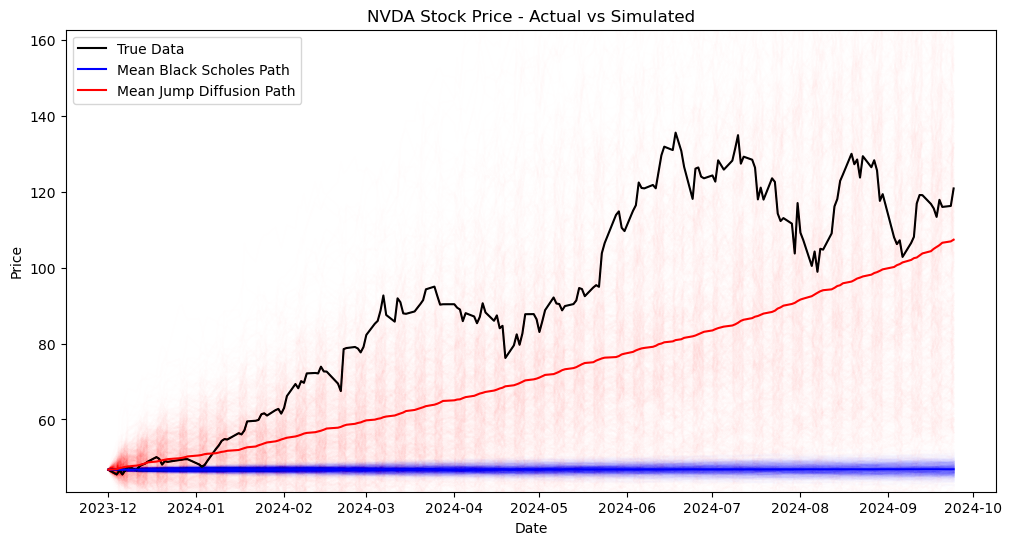

In [36]:
T = len(df) / 252
N = int(T * 252) -1
simulated_paths_bs = black_scholes_model(df["Close"].iloc[0], fit_mu_bs, fit_sigma_bs, T, N)
simulated_paths_jd = jump_diffusion_model(df["Close"].iloc[0], fit_mu_jd, fit_sigma_jd, fit_lambda_j_jd, fit_mu_j_jd, fit_sigma_j_jd, T, N)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="True Data", color='black')
for SP,JD in zip(simulated_paths_bs,simulated_paths_jd):
    plt.plot(df.index, SP.T, alpha=0.005, color='blue')
    plt.plot(df.index, JD.T, alpha=0.005, color='red')
plt.plot(df.index, np.mean(simulated_paths_bs, axis=0), label="Mean Black Scholes Path", color='blue')
plt.plot(df.index, np.mean(simulated_paths_jd, axis=0), label="Mean Jump Diffusion Path", color='red')
plt.title(f"{tickers} Stock Price - Actual vs Simulated")
plt.xlabel("Date")
plt.ylabel("Price")
plt.ylim(min(df["Close"])*0.9,max(df["Close"])*1.2)
plt.legend()
plt.show()